In [15]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

from sklearn.metrics import confusion_matrix, classification_report

In [16]:
train_csv = "stanford_cars_with_class_names_train.csv"
test_csv  = "stanford_cars_with_class_names_test.csv"

train_df = pd.read_csv(train_csv)
test_df = pd.read_csv(test_csv)

In [17]:
num_classes = train_df["class_id"].nunique()
num_classes

196

In [18]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1)
])
# augmenting input images
def augment(image, label):
    return data_augmentation(image), label

In [19]:
IMG_SIZE = 224

def df_to_dataset(dataframe, base_dir, shuffle=True, batch_size=32):
    df_dict = {
        'x1': dataframe['x1'].values,
        'y1': dataframe['y1'].values,
        'x2': dataframe['x2'].values,
        'y2': dataframe['y2'].values,
        'image': dataframe['image'].values,
        'class_id': dataframe['class_id'].values
    }
    
    ds = tf.data.Dataset.from_tensor_slices(df_dict)

    def load_and_preprocess(row):
        
        img_path = tf.strings.join([base_dir, row['image']], separator="/")

        image_file = tf.io.read_file(img_path)
        img = tf.image.decode_jpeg(image_file, channels=3)
        
        # cropping
        cropped = img[row['y1']:row['y2'], row['x1']:row['x2'], :]

        # resizing & preprocessing for ResNet
        cropped = tf.image.resize(cropped, (IMG_SIZE, IMG_SIZE))
        cropped = preprocess_input(cropped)

        return cropped, row['class_id']

        
    ds = ds.map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    
    # after shuffling
    ds = ds.batch(batch_size)
    
    ds = ds.map(augment, num_parallel_calls=tf.data.AUTOTUNE)
    
    return ds.prefetch(tf.data.AUTOTUNE)

In [20]:
BATCH_SIZE = 8

train_ds = df_to_dataset(train_df, base_dir="cars_train", shuffle=True, batch_size=BATCH_SIZE)
test_ds = df_to_dataset(test_df, base_dir="cars_test", shuffle=False, batch_size=BATCH_SIZE)

In [21]:
# actual model
base_model = ResNet50 (weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

for layer in base_model.layers[:140]:
    layer.trainable = False

x = layers.GlobalAveragePooling2D()(base_model.output)
x = layers.Dropout(0.2)(x)  

outputs = layers.Dense(num_classes, activation='softmax')(x)

model = models.Model(inputs=base_model.input, outputs=outputs)

model.compile (optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_3[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,989,316 (91.51 MB)

 Trainable params: 15,379,652 (58.67 MB)

 Non-trainable params: 8,609,664 (32.84 MB)

In [8]:
# #training the model
# EPOCHS = 10  
# history = model.fit(train_ds, validation_data=test_ds, epochs=EPOCHS)

Epoch 1/10


2025-04-07 18:11:41.688044: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 7931 of 8144
2025-04-07 18:11:41.917683: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


1018/1018 ━━━━━━━━━━━━━━━━━━━━ 369s 341ms/step - accuracy: 0.0873 - loss: 4.8272 - val_accuracy: 0.4509 - val_loss: 2.1925
Epoch 2/10
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 345s 330ms/step - accuracy: 0.5240 - loss: 2.0034 - val_accuracy: 0.6482 - val_loss: 1.2704
Epoch 3/10
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 356s 341ms/step - accuracy: 0.7443 - loss: 1.0419 - val_accuracy: 0.7123 - val_loss: 1.0161
Epoch 4/10
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 346s 330ms/step - accuracy: 0.8281 - loss: 0.6887 - val_accuracy: 0.7531 - val_loss: 0.8795
Epoch 5/10
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 349s 334ms/step - accuracy: 0.8678 - loss: 0.5001 - val_accuracy: 0.7733 - val_loss: 0.8113
Epoch 6/10
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 356s 341ms/step - accuracy: 0.8977 - loss: 0.3808 - val_accuracy: 0.7867 - val_loss: 0.7719
Epoch 7/10
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 355s 340ms/step - accuracy: 0.9258 - loss: 0.2937 - val_accuracy: 0.7883 - val_loss: 0.7530
Epoch 8/10
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 350s 335ms/step - accuracy: 0.9

In [24]:
#evaluating the model
def model_eval(model):
    all_test_images = []
    all_test_labels = []
    
    for img_batch, label_batch in test_ds:
        all_test_images.append(img_batch)
        all_test_labels.append(label_batch)
    
    all_test_images = tf.concat(all_test_images, axis=0)
    all_test_labels = tf.concat(all_test_labels, axis=0)
    
    # predictions
    pred_probs = model.predict(all_test_images)
    pred_labels = tf.argmax(pred_probs, axis=1)
    
    # confusion matrix
    cm = confusion_matrix(all_test_labels.numpy(), pred_labels.numpy())
    print("Confusion matrix shape:", cm.shape)
    
    # classification report
    print(classification_report(all_test_labels.numpy(), pred_labels.numpy()))


In [ ]:
# model_eval(model)

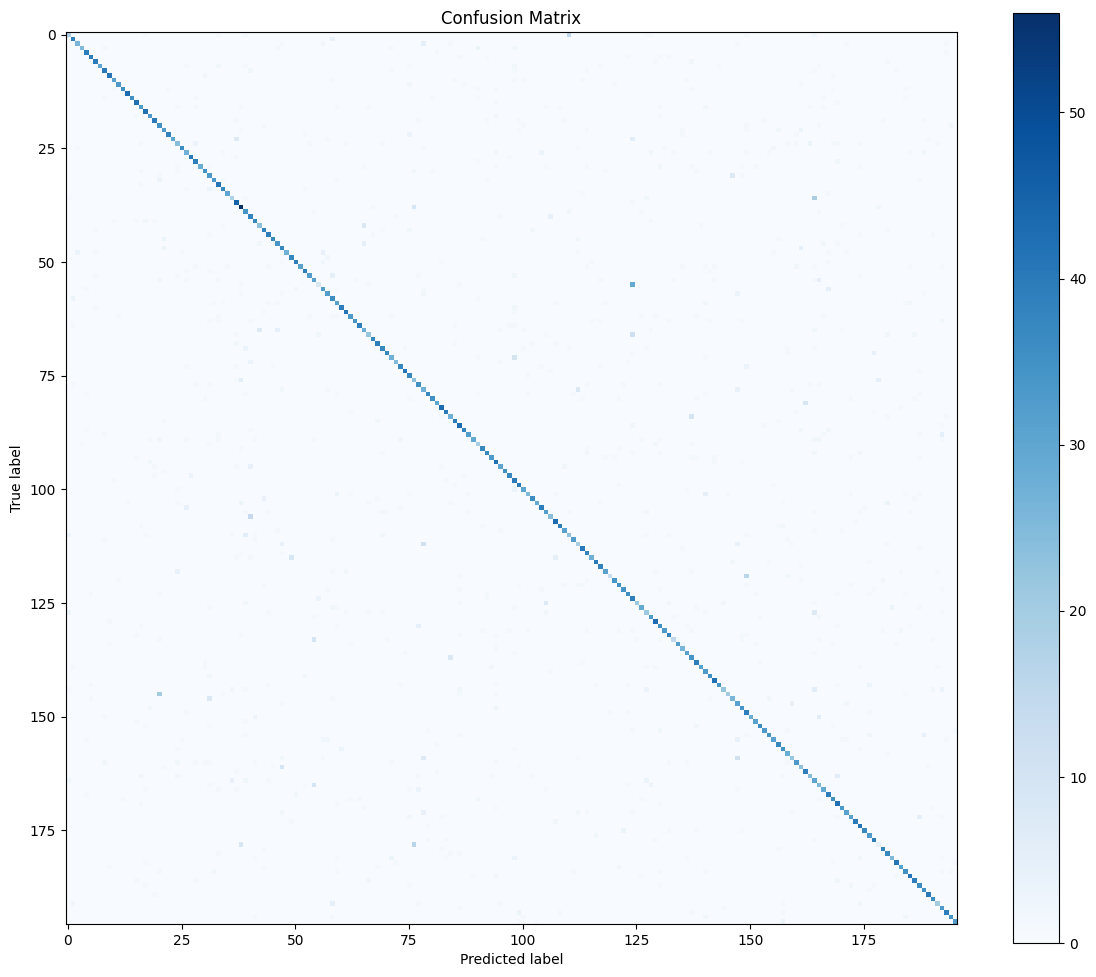

In [10]:
# graph
plt.figure(figsize=(12, 10))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.tight_layout()
plt.show()

In [14]:
# model.save('resnet_v1.keras')

In [22]:
# Load the previously saved model
model = tf.keras.models.load_model('resnet_v1.keras')
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

# Set additional training parameters
additional_epochs = 30  # However many more epochs you want to train

# Continue training the model
history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=additional_epochs,
    initial_epoch=10  # Start from where you left off (assuming you trained 10 epochs before)
)



Epoch 11/30


/mnt/home/fransenq/.local/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 46 variables whereas the saved optimizer has 90 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1018/1018 ━━━━━━━━━━━━━━━━━━━━ 342s 317ms/step - accuracy: 0.9546 - loss: 0.1713 - val_accuracy: 0.8107 - val_loss: 0.7166
Epoch 12/30
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 327s 313ms/step - accuracy: 0.9583 - loss: 0.1634 - val_accuracy: 0.8066 - val_loss: 0.7562
Epoch 13/30
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 328s 314ms/step - accuracy: 0.9651 - loss: 0.1380 - val_accuracy: 0.8030 - val_loss: 0.7574
Epoch 14/30
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 327s 313ms/step - accuracy: 0.9606 - loss: 0.1404 - val_accuracy: 0.8188 - val_loss: 0.7181
Epoch 15/30
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 326s 312ms/step - accuracy: 0.9680 - loss: 0.1250 - val_accuracy: 0.8152 - val_loss: 0.7148
Epoch 16/30
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 325s 312ms/step - accuracy: 0.9655 - loss: 0.1290 - val_accuracy: 0.8255 - val_loss: 0.7187
Epoch 17/30
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 327s 313ms/step - accuracy: 0.9730 - loss: 0.1034 - val_accuracy: 0.8317 - val_loss: 0.6796
Epoch 18/30
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 329s 315ms/step - accura

In [23]:
model.save('resnet_v2_30epochs.keras')  # New name to avoid overwriting

In [25]:
model_eval(model)

2025-04-08 16:59:54.983328: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


252/252 ━━━━━━━━━━━━━━━━━━━━ 125s 486ms/step
Confusion matrix shape: (196, 196)
              precision    recall  f1-score   support

           0       0.65      0.52      0.58        42
           1       0.82      0.93      0.87        43
           2       0.79      0.89      0.84        38
           3       0.93      0.85      0.89        33
           4       0.95      0.98      0.96        41
           5       0.93      0.86      0.89        44
           6       0.95      0.89      0.92        44
           7       0.82      0.90      0.86        41
           8       1.00      0.89      0.94        47
           9       1.00      0.91      0.95        44
          10       1.00      0.89      0.94        37
          11       0.92      0.92      0.92        38
          12       0.82      0.88      0.85        42
          13       0.92      0.84      0.88        43
          14       0.92      0.88      0.90        41
          15       0.65      0.95      0.77        44
 